# Thư viện:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import pickle
import gzip
import pandas as pd
import time
import pickle
import pylab as pl
from sklearn.metrics import accuracy_score
from datetime import datetime

# Đọc dữ liệu:

In [6]:
def read_mnist(mnist_file):
    """
    Reads MNIST data.
    
    Parameters
    ----------
    mnist_file : string
        The name of the MNIST file (e.g., 'mnist.pkl.gz').
    
    Returns
    -------
    (train_X, train_Y, val_X, val_Y, test_X, test_Y) : tuple
        train_X : numpy array, shape (N=50000, d=784)
            Input vectors of the training set.
        train_Y: numpy array, shape (N=50000)
            Outputs of the training set.
        val_X : numpy array, shape (N=10000, d=784)
            Input vectors of the validation set.
        val_Y: numpy array, shape (N=10000)
            Outputs of the validation set.
        test_X : numpy array, shape (N=10000, d=784)
            Input vectors of the test set.
        test_Y: numpy array, shape (N=10000)
            Outputs of the test set.
    """
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [7]:
# Test
train_X, train_Y, val_X, val_Y, test_X, test_Y = read_mnist('mnist.pkl.gz')

print('train_X.shape =', train_X.shape)
print('train_Y.shape =', train_Y.shape)
print('val_X.shape   =', val_X.shape)
print('val_Y.shape   =', val_Y.shape)
print('test_X.shape  =', test_X.shape)
print('test_Y.shape  =', test_Y.shape)

print('\ntrain_X: min = %.3f, max = %.3f' %(train_X.min(), train_X.max()))
print('train_Y: min = %d, max = %d' %(train_Y.min(), train_Y.max()))

train_X.shape = (50000, 784)
train_Y.shape = (50000,)
val_X.shape   = (10000, 784)
val_Y.shape   = (10000,)
test_X.shape  = (10000, 784)
test_Y.shape  = (10000,)

train_X: min = 0.000, max = 0.996
train_Y: min = 0, max = 9


## Hiển thị cấu trúc của tập huấn luyện:

In [5]:
train_data_X = pd.DataFrame(train_X)
train_data_X.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_data_X.describe().head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000739,0.000354,0.000204,0.000090,0.000071,0.000009,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022778,0.015422,0.012079,0.007217,0.007181,0.001483,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


# Huấn luyện SVM:

**Mục tiêu:** Xét các giá trị siêu tham số khác nhau cho mỗi lần huấn luyện, đưa ra kết luận về sự ảnh hường của việc chọn tham số.

- ##   <font color=red> Linear Kernel </font>

Mục tiêu: Set các giá trị siêu tham số khác nhau cho mỗi lần huấn luyện, đưa ra kết luận về sự ảnh hường của việc chọn tham số.

Dựa trên : https://queirozf.com/entries/choosing-c-hyperparameter-for-svm-classifiers-examples-with-scikit-learn

Độ lỗi: https://stackoverflow.com/questions/10318884/find-out-error-rate-using-sklearn

\- Hàm lưu và chạy model để dùng cho tập test:

In [8]:
# save the model to disk
def save_model(model, mode,  C_k, gamma_k = 1):
    if mode == 'linear':
        file_name = mode + '_C' + str(C_k) + '.sav'
        pickle.dump(model, open(file_name, 'wb'))
    else:
        file_name = mode + '_C' + str(C_k) + '_gamma' + str(gamma_k) + '.sav'
        pickle.dump(model, open(file_name, 'wb'))
        
# load the model from disk
def load_model(file_name):
    loaded_model = pickle.load(open(file_name, 'rb'))
    return loaded_model

\- Hàm lưu thông tin, kết quả training vào file csv:

In [9]:
def save_results(file_name, list_C, list_gamma, list_trai_error, list_val_error, list_time):
    df = pd.DataFrame({'C': list_C})
    if list_gamma:
        df['Gamma'] = list_gamma
    df['E_train'] = list_trai_error
    df['E_Validation'] = list_val_error
    df['Time'] = list_time
    df.to_csv(file_name, index = False, encoding='utf-8')

\- Chạy huấn luyện SVM (Linear Kernel):

In [8]:
"""
Create list of numbers C, gamma, train error, validation error, training time:
"""
list_C = []
list_gamma = []
list_trai_error = []
list_val_error = []
list_time = []

for k in range(-3,4):
    
    C = 10**k
    
    #Training:
    start_time = datetime.now()
    svclassifier = SVC(C = C,kernel='linear')
    svclassifier.fit(train_X, train_Y)
    train_time = datetime.now() - start_time
    
    #Save model:
    save_model(svclassifier, 'linear', k)
    
    #Get Y predict from input X
    y_train_pred = svclassifier.predict(train_X)  
    y_val_pred = svclassifier.predict(val_X)
    
    #Get error:
    train_error = 1 -  (accuracy_score(train_Y, y_train_pred, normalize=False) / float(train_Y.size))
    val_error = 1 -  (accuracy_score(val_Y, y_val_pred, normalize=False) / float(val_Y.size))
    
    #Append values to list:
    list_C.append(C)
    list_trai_error.append(train_error)
    list_val_error.append(val_error)
    list_time.append(train_time)
    
    #Print results:
    print("C: {}  |  train error: {}  |  validation error: {}  |  time: {}".format(C, train_error, val_error, train_time))
    
#Save results:
save_results('result_linear.csv', list_C, list_gamma, list_trai_error, list_val_error, list_time)    

C: 0.001  |  train error: 0.07609999999999995  |  validation error: 0.06910000000000005  |  time: 0:14:53.656299
C: 0.01  |  train error: 0.05593999999999999  |  validation error: 0.05630000000000002  |  time: 0:07:43.041460
C: 0.1  |  train error: 0.04188000000000003  |  validation error: 0.051899999999999946  |  time: 0:05:17.990457
C: 1  |  train error: 0.02754000000000001  |  validation error: 0.057699999999999974  |  time: 0:07:06.407389
C: 10  |  train error: 0.016920000000000046  |  validation error: 0.0716  |  time: 0:09:36.657049
C: 100  |  train error: 0.013000000000000012  |  validation error: 0.07769999999999999  |  time: 0:26:19.362491
C: 1000  |  train error: 0.011340000000000017  |  validation error: 0.07689999999999997  |  time: 2:53:41.278142


- ##   <font color=red> Gaussian/RBF Kernel </font>

\- Chạy huấn luyện SVM (Gaussian/RBF Kernel):

In [ ]:
"""
Create list of numbers C, gamma, train error, validation error, training time:
"""
list_C = []
list_gamma = []
list_trai_error = []
list_val_error = []
list_time = []



C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1]
for C in C_range:
    for gamma in gamma_range:
        #Training:
        start_time = datetime.now()
        svclassifier = SVC(C = C,gamma = gamma,kernel='rbf')
        svclassifier.fit(train_X, train_Y)
        train_time = datetime.now() - start_time

        #Save model:
        save_model(svclassifier, 'Gaussian', C, gamma)

        #Get Y predict from input X
        y_train_pred = svclassifier.predict(train_X)  
        y_val_pred = svclassifier.predict(val_X)

        #Get error:
        train_error = 1 -  (accuracy_score(train_Y, y_train_pred, normalize=False) / float(train_Y.size))
        val_error = 1 -  (accuracy_score(val_Y, y_val_pred, normalize=False) / float(val_Y.size))
        
        #Append values to list:
        list_C.append(C)
        list_gamma.append(gamma)
        list_trai_error.append(train_error)
        list_val_error.append(val_error)
        list_time.append(train_time)
        
        #Print results:
        print("C: {}  |  gamma: {}  |  train error: {}  |  validation error: {}  |  time: {}"
              .format(C, gamma, train_error, val_error, train_time))
        
#Save results:
save_results('result_gaussian.csv', list_C, list_gamma, list_trai_error, list_val_error, list_time)   
            

# Đánh giá SVM:

\- Chọn model có độ lỗi nhỏ nhất với tập validation để chạy với tập test. Ta so sánh các kết quả của Linear Kernel và Gaussian/RBF Kernel.

In [58]:
df_1 = pd.read_csv('result_linear.csv')
df_1

,C,E_train,E_Validation,Time
0,0.001,0.07610,0.0691,14:53.7
1,0.010,0.05594,0.0563,07:43.0
2,0.100,0.04188,0.0519,05:18.0
3,1.000,0.02754,0.0577,07:06.4
4,10.000,0.01692,0.0716,09:36.7
5,100.000,0.01300,0.0777,26:19.4
6,1000.000,0.01134,0.0769,53:41.3


Linear Kernel: Min validation is 0.0519 error at C = 0.1


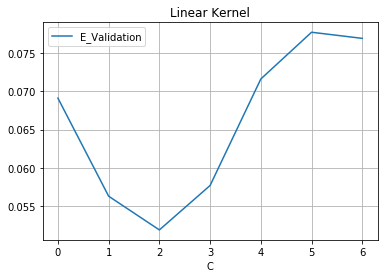

In [55]:
#Find C (min Validation error at C_min)
min_E_linear = df_1.min(axis=0)['E_Validation']
index_min1 = df_1.index[df_1['E_Validation'] == min_E_linear].tolist()
C_min_linear = df_1.iloc[index_min1[0]]['C']

#Plot line
df_1['C'] = range(0,7)
df_1.plot.line(x='C', y='E_Validation', title = "Linear Kernel", grid = True)


print("Linear Kernel: Min validation is {} error at C = {}"
      .format(min_E_linear, C_min_linear))

In [10]:
df_2 = pd.read_csv('result_gaussian.csv')
df_2

,C,gamma,E_train,E_Validation,Time
0,0.01,0.0001,0.88644,0.8936,1:18:36.414841
1,0.01,0.0010,0.25374,0.2279,1:02:59.338034
2,0.01,0.0100,0.09390,0.0822,0:33:04.407952
3,0.01,0.1000,0.78430,0.7828,1:12:51.086840
4,0.01,1.0000,0.88644,0.8936,1:27:47.568377
5,0.10,0.0001,0.23658,0.2105,1:02:31.281172
6,0.10,0.0010,0.09824,0.0861,0:23:53.280465
7,0.10,0.0100,0.04702,0.0422,0:11:16.622321
8,0.10,0.1000,0.28952,0.3125,0:50:24.369580
9,0.10,1.0000,0.88644,0.8936,1:30:14.722008


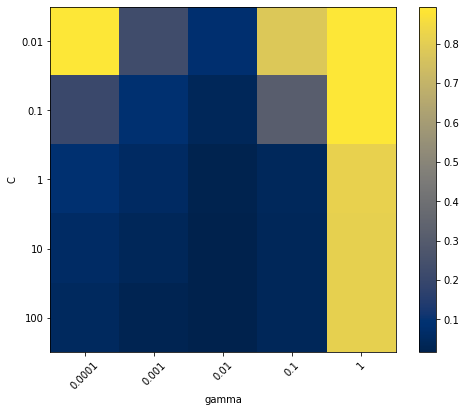

In [30]:
# Make a nice figure
scores = df_2['E_Validation']
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest',cmap='cividis')
pl.xlabel('gamma')
pl.ylabel('C')
pl.colorbar()
pl.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pl.yticks(np.arange(len(C_range)), C_range)
pl.show()

Gaussian/RBF Kernel: Min validation is 0.0165 error at C = 10.0, gamma = 0.01


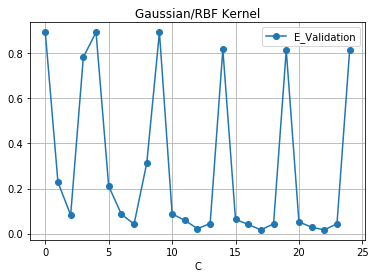

In [11]:
#Find C and gamma (min Validation error at C_min_gaussian, gamma_min_gaussian)
min_E_gaussian = df_2.min(axis=0)['E_Validation']
index_min2 = df_2.index[df_2['E_Validation'] == min_E_gaussian].tolist()
C_min_gaussian = df_2.iloc[index_min2[0]]['C']
gamma_min_gaussian = df_2.iloc[index_min2[0]]['gamma']

#Plot line
df_2['C'] = range(0,25)
df_2.plot.line(x='C', y='E_Validation',  marker='o', title = "Gaussian/RBF Kernel", grid = True)

print("Gaussian/RBF Kernel: Min validation is {} error at C = {}, gamma = {}"
      .format(min_E_gaussian, C_min_gaussian, gamma_min_gaussian))

**Vậy với độ lỗi nhỏ nhất 0.0165 tại C = 10 và gamma = 0.01 của phương pháp Gaussian/RBF Kernel.**

=> Thực hiện hàm dự đoán trên với tập test.

link model training with C = 10 and gamma = 0.01: https://drive.google.com/file/d/17l28-j2ZtMS1ZGcS9vA4J3YkbuXkWI8m/view?usp=sharing

In [15]:
#Results with test data
name_file = 'Gaussian_C' + str(C_min_gaussian) + '_gamma' + str(gamma_min_gaussian) + '.sav'
test = load_model(name_file)
y_test_pred = test.predict(test_X)
test_error = 1 -  (accuracy_score(test_Y, y_test_pred, normalize=False) / float(test_Y.size))
print('C: {}, gamma: {}, error: {}'.format(C,gamma,test_error))

C: 10, gamma: 0.01, error: 0.018000000000000016


### * Cải thiện tốc độ chạy:

Trước tiên, ta đưa ra trường hợp ví dụ để đo thời gian tiêu tốn theo từng bước của chương trình. 

Cụ thể, xét tại giá trị $C = 1$, ta có các mốc thời gian tiêu tốn lần lượt như sau:

In [102]:
k = 0
t = 10**k

#Time 1
start_time1 = datetime.now()
svclassifier = SVC(C = t,kernel='linear')
svclassifier.fit(train_X, train_Y)
train_time1 = datetime.now() - start_time1

#Time 2
start_time2 = datetime.now()
y_train_pred = svclassifier.predict(train_X)  
y_val_pred = svclassifier.predict(val_X)
train_time2 = datetime.now() - start_time2

#Time 3
start_time3 = datetime.now()
train_error = 1 -  (accuracy_score(train_Y, y_train_pred, normalize=False) / float(train_Y.size))
val_error = 1 -  (accuracy_score(val_Y, y_val_pred, normalize=False) / float(val_Y.size))
train_time3 = datetime.now() - start_time3

#Output
print("C: {},train error: {}, validation error: {}, time: {} {} {}"
      .format(t, train_error, val_error, train_time1, train_time2, train_time3))

C: 1,train error: 0.02754000000000001, validation error: 0.057699999999999974, time: 0:07:05.583391 0:12:01.266251 0:00:00.005985


Cách thức:
- Đẩy nhanh thời gian thực thi thuật toán bằng cách chỉnh sửa các tham số cài đặt trong document của modul.
- Cài đặt chạy CPU đa nhân một cách tối đa. 

link tham khảo: https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python

In [88]:
import multiprocessing 
from datetime import datetime